In [1]:
%reset -f

import warnings
warnings.simplefilter("ignore")

import json
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

plt.style.use('dark_background')
sns.set_theme(style="darkgrid")
sns.set_context("notebook")
plt.rcParams['figure.facecolor'] = '#1B202B'
plt.rcParams['axes.facecolor'] = '#1B202B'
plt.rcParams['text.color'] = '#d4d4d4'
plt.rcParams['axes.labelcolor'] = '#d4d4d4'
plt.rcParams['xtick.color'] = '#d4d4d4'
plt.rcParams['ytick.color'] = '#d4d4d4'
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['savefig.facecolor'] = '#1b202b'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.5
sns.set_palette("deep")

model_dir = "./models"
dataset_dir = "../datasets/net-dataset"
comp_dir = "../datasets/march-machine-learning-mania-2025"

In [2]:
print("stats\n")

stats = pd.read_csv(f"{dataset_dir}/season_2025.csv")

stats = pd.concat([
    stats.select_dtypes("int").astype("int32"),
    stats.select_dtypes("float").astype("float32"),
], axis=1)

display(stats.shape, stats.iloc[[stats.index.min(), stats.index.max()]])
print()

stats



(726, 58)

,Season,TeamID,Score_poss_o,FGM_poss_o,FGA_poss_o,FGM3_poss_o,FGA3_poss_o,FTM_poss_o,FTA_poss_o,OR_poss_o,DR_poss_o,Ast_poss_o,TO_poss_o,Stl_poss_o,Blk_poss_o,PF_poss_o,Score_poss_d,FGM_poss_d,FGA_poss_d,FGM3_poss_d,FGA3_poss_d,FTM_poss_d,FTA_poss_d,OR_poss_d,DR_poss_d,Ast_poss_d,TO_poss_d,Stl_poss_d,Blk_poss_d,PF_poss_d,sos_Score_poss_o,sos_FGM_poss_o,sos_FGA_poss_o,sos_FGM3_poss_o,sos_FGA3_poss_o,sos_FTM_poss_o,sos_FTA_poss_o,sos_OR_poss_o,sos_DR_poss_o,sos_Ast_poss_o,sos_TO_poss_o,sos_Stl_poss_o,sos_Blk_poss_o,sos_PF_poss_o,sos_Score_poss_d,sos_FGM_poss_d,sos_FGA_poss_d,sos_FGM3_poss_d,sos_FGA3_poss_d,sos_FTM_poss_d,sos_FTA_poss_d,sos_OR_poss_d,sos_DR_poss_d,sos_Ast_poss_d,sos_TO_poss_d,sos_Stl_poss_d,sos_Blk_poss_d,sos_PF_poss_d
0,2025,1101,0.963398,0.342737,0.785438,0.059869,0.202676,0.218055,0.305387,0.118090,0.278473,0.174664,0.198282,0.144455,0.038997,0.298247,1.019049,0.338018,0.733760,0.082146,0.247547,0.260868,0.372985,0.127104,0.323587,0.177612,0.229230,0.112118,0.063829,0.254762,1.018438,0.355316,0.825067,0.099417,0.305568,0.208388,0.292848,0.132596,0.321734,0.181639,0.178676,0.100344,0.051079,0.256303,1.047087,0.365335,0.826247,0.101833,0.300998,0.214584,0.300272,0.128371,0.323762,0.193434,0.170004,0.107262,0.053681,0.257105
725,2025,3480,0.899466,0.322678,0.797620,0.080165,0.281839,0.173944,0.257134,0.140668,0.314107,0.172935,0.229908,0.098820,0.031764,0.235958,0.974593,0.360209,0.833046,0.079652,0.265844,0.174524,0.244536,0.136473,0.303894,0.181119,0.195832,0.107048,0.042109,0.250117,0.914648,0.331866,0.814081,0.085874,0.276438,0.165042,0.230668,0.129117,0.312529,0.168998,0.213542,0.102238,0.037615,0.237132,0.946776,0.345428,0.821794,0.086808,0.271276,0.169112,0.238518,0.135945,0.323726,0.178865,0.209203,0.106593,0.042306,0.231166


In [3]:
print("matchups\n")

matchups = pd.read_csv(f"{comp_dir}/SampleSubmissionStage2.csv")
matchups[["Season", "TeamID_1", "TeamID_2"]] = matchups["ID"].str.split('_', expand=True).astype("int32")
matchups = matchups.drop(columns="Pred")
# display(matchups.shape, matchups.iloc[[matchups.index.min(), matchups.index.max()]])
# print()

teams = pd.concat([
    pd.read_csv(f"{comp_dir}/MTeams.csv"),
    pd.read_csv(f"{comp_dir}/WTeams.csv"),
])[["TeamID", "TeamName"]]

for i in [1, 2]:
    matchups = pd.merge(
        matchups, 
        teams, 
        left_on=[f"TeamID_{i}"],
        right_on=["TeamID"],
        suffixes=["_1", "_2"],
    ).drop(columns=["TeamID"])

for i in [1, 2]:
    matchups = pd.merge(
        matchups, 
        stats, 
        left_on=["Season", f"TeamID_{i}"],
        right_on=["Season", "TeamID"],
        suffixes=["_1", "_2"],
    ).drop(columns=["TeamID"])

display(matchups.shape, matchups.iloc[[matchups.index.min(), matchups.index.max()]])
print()

print("\nX_df\n")
X_df = matchups.drop(columns=["ID", "Season", "TeamID_1", "TeamID_2", "TeamName_1", "TeamName_2"])
# display(X_df.shape, X_df.iloc[[X_df.index.min(), X_df.index.max()]])
# print()

matchups



(131407, 118)

,ID,Season,TeamID_1,TeamID_2,TeamName_1,TeamName_2,Score_poss_o_1,FGM_poss_o_1,FGA_poss_o_1,FGM3_poss_o_1,FGA3_poss_o_1,FTM_poss_o_1,FTA_poss_o_1,OR_poss_o_1,DR_poss_o_1,Ast_poss_o_1,TO_poss_o_1,Stl_poss_o_1,Blk_poss_o_1,PF_poss_o_1,Score_poss_d_1,FGM_poss_d_1,FGA_poss_d_1,FGM3_poss_d_1,FGA3_poss_d_1,FTM_poss_d_1,FTA_poss_d_1,OR_poss_d_1,DR_poss_d_1,Ast_poss_d_1,TO_poss_d_1,Stl_poss_d_1,Blk_poss_d_1,PF_poss_d_1,sos_Score_poss_o_1,sos_FGM_poss_o_1,sos_FGA_poss_o_1,sos_FGM3_poss_o_1,sos_FGA3_poss_o_1,sos_FTM_poss_o_1,sos_FTA_poss_o_1,sos_OR_poss_o_1,sos_DR_poss_o_1,sos_Ast_poss_o_1,sos_TO_poss_o_1,sos_Stl_poss_o_1,sos_Blk_poss_o_1,sos_PF_poss_o_1,sos_Score_poss_d_1,sos_FGM_poss_d_1,sos_FGA_poss_d_1,sos_FGM3_poss_d_1,sos_FGA3_poss_d_1,sos_FTM_poss_d_1,sos_FTA_poss_d_1,sos_OR_poss_d_1,sos_DR_poss_d_1,sos_Ast_poss_d_1,sos_TO_poss_d_1,sos_Stl_poss_d_1,sos_Blk_poss_d_1,sos_PF_poss_d_1,Score_poss_o_2,FGM_poss_o_2,FGA_poss_o_2,FGM3_poss_o_2,FGA3_poss_o_2,FTM_poss_o_2,FTA_poss_o_2,OR_poss_o_2,DR_poss_o_2,Ast_poss_o_2,TO_poss_o_2,Stl_poss_o_2,Blk_poss_o_2,PF_poss_o_2,Score_poss_d_2,FGM_poss_d_2,FGA_poss_d_2,FGM3_poss_d_2,FGA3_poss_d_2,FTM_poss_d_2,FTA_poss_d_2,OR_poss_d_2,DR_poss_d_2,Ast_poss_d_2,TO_poss_d_2,Stl_poss_d_2,Blk_poss_d_2,PF_poss_d_2,sos_Score_poss_o_2,sos_FGM_poss_o_2,sos_FGA_poss_o_2,sos_FGM3_poss_o_2,sos_FGA3_poss_o_2,sos_FTM_poss_o_2,sos_FTA_poss_o_2,sos_OR_poss_o_2,sos_DR_poss_o_2,sos_Ast_poss_o_2,sos_TO_poss_o_2,sos_Stl_poss_o_2,sos_Blk_poss_o_2,sos_PF_poss_o_2,sos_Score_poss_d_2,sos_FGM_poss_d_2,sos_FGA_poss_d_2,sos_FGM3_poss_d_2,sos_FGA3_poss_d_2,sos_FTM_poss_d_2,sos_FTA_poss_d_2,sos_OR_poss_d_2,sos_DR_poss_d_2,sos_Ast_poss_d_2,sos_TO_poss_d_2,sos_Stl_poss_d_2,sos_Blk_poss_d_2,sos_PF_poss_d_2
0,2025_1101_1102,2025,1101,1102,Abilene Chr,Air Force,0.963398,0.342737,0.785438,0.059869,0.202676,0.218055,0.305387,0.118090,0.278473,0.174664,0.198282,0.144455,0.038997,0.298247,1.019049,0.338018,0.733760,0.082146,0.247547,0.260868,0.372985,0.127104,0.323587,0.177612,0.229230,0.112118,0.063829,0.254762,1.018438,0.355316,0.825067,0.099417,0.305568,0.208388,0.292848,0.132596,0.321734,0.181639,0.178676,0.100344,0.051079,0.256303,1.047087,0.365335,0.826247,0.101833,0.300998,0.214584,0.300272,0.128371,0.323762,0.193434,0.170004,0.107262,0.053681,0.257105,0.965239,0.330836,0.781041,0.124514,0.369940,0.179053,0.282471,0.092614,0.324147,0.205808,0.187285,0.086439,0.044763,0.277326,1.121273,0.402782,0.840700,0.106933,0.297377,0.208775,0.298395,0.121191,0.363573,0.190443,0.149197,0.103878,0.050411,0.268861,1.066900,0.377442,0.841200,0.111792,0.324409,0.200224,0.278698,0.122976,0.336836,0.197336,0.159148,0.093554,0.049741,0.248756,1.045811,0.369129,0.833412,0.113857,0.334173,0.193697,0.274158,0.119409,0.332479,0.197052,0.165367,0.092135,0.048760,0.255037
131406,2025_3479_3480,2025,3479,3480,Mercyhurst,West Georgia,0.853335,0.291744,0.721370,0.092316,0.287601,0.177532,0.243218,0.071604,0.309497,0.141434,0.243218,0.078114,0.017161,0.256237,0.948972,0.356159,0.800033,0.064756,0.221348,0.171898,0.248428,0.115972,0.330256,0.170132,0.206631,0.118916,0.032967,0.262557,0.863030,0.315585,0.807401,0.083793,0.273216,0.148067,0.205587,0.123168,0.315765,0.177942,0.225309,0.094576,0.037304,0.235417,0.947380,0.346968,0.831799,0.093702,0.289379,0.159742,0.221994,0.134860,0.330536,0.199487,0.205383,0.111322,0.040888,0.223541,0.899466,0.322678,0.797620,0.080165,0.281839,0.173944,0.257134,0.140668,0.314107,0.172935,0.229908,0.098820,0.031764,0.235958,0.974593,0.360209,0.833046,0.079652,0.265844,0.174524,0.244536,0.136473,0.303894,0.181119,0.195832,0.107048,0.042109,0.250117,0.914648,0.331866,0.814081,0.085874,0.276438,0.165042,0.230668,0.129117,0.312529,0.168998,0.213542,0.102238,0.037615,0.237132,0.946776,0.345428,0.821794,0.086808,0.271276,0.169112,0.238518,0.135945,0.323726,0.178865,0.209203,0.106593,0.042306,0.231166




X_df



In [4]:
n_splits = 5
xgb_models = [None] * n_splits
nn_models = [None] * n_splits

for path in glob(f"{model_dir}/*"):
    model_type, brier_score, fold_n = path.split("/")[-1].split(".")[0].split("_")
    i = int(fold_n) - 1
    if model_type == "xgb":
        xgb_models[i] = xgb.XGBRegressor()
        xgb_models[i].load_model(path)
    elif model_type == "nn":
        with open(path) as f:
            nn_models[i] = json.load(f)

y_preds = []

In [5]:
print(f"xgb ", end="", flush=True)
X_cudf = X_df

for fold_n, m in enumerate(xgb_models, 1):
    print(f"{fold_n} ", end="", flush=True)
    y_preds.append(m.predict(X_cudf))

xgb 1 2 3 4 5 

In [6]:
print(f"nn ", end="", flush=True)
device = "cuda"

X = torch.as_tensor(
    StandardScaler().fit_transform(X_df),
    dtype=torch.float32,
    device=device,
)

for fold_n, m_py in enumerate(nn_models, 1):
    print(f"{fold_n} ", end="", flush=True)

    m = {
        "w": [torch.tensor(w, device=device) for w in m_py["w"]], 
        "b": [torch.tensor(b, device=device) for b in m_py["b"]]
    }

    def forward():
        return F.leaky_relu(X @ m["w"][0] + m["b"][0], negative_slope=0.1) @ m["w"][1] + m["b"][1]

    y_preds.append(forward().cpu().numpy().flatten())

nn 1 2 3 4 5 

In [7]:
print("submission\n")

submission = matchups[["ID", "TeamID_1", "TeamID_2", "TeamName_1", "TeamName_2"]]
submission["Pred_margin"] = np.mean(y_preds, axis=0)
submission["Pred"] = 1 / (1 + np.exp(-submission["Pred_margin"] * 0.175))
submission[["ID", "Pred"]].to_csv("submission.csv", index=False)
submission

submission



,ID,TeamID_1,TeamID_2,TeamName_1,TeamName_2,Pred_margin,Pred
0,2025_1101_1102,1101,1102,Abilene Chr,Air Force,-0.032739,0.498568
1,2025_1101_1103,1101,1103,Abilene Chr,Akron,-6.184379,0.253077
2,2025_1101_1104,1101,1104,Abilene Chr,Alabama,-17.400698,0.045429
3,2025_1101_1105,1101,1105,Abilene Chr,Alabama A&M,5.525233,0.724504
4,2025_1101_1106,1101,1106,Abilene Chr,Alabama St,1.554789,0.567605
...,...,...,...,...,...,...,...
131402,2025_3477_3479,3477,3479,East Texas A&M,Mercyhurst,0.387899,0.516964
131403,2025_3477_3480,3477,3480,East Texas A&M,West Georgia,-3.691308,0.343896
131404,2025_3478_3479,3478,3479,Le Moyne,Mercyhurst,-2.828356,0.378725
131405,2025_3478_3480,3478,3480,Le Moyne,West Georgia,-6.181085,0.253186


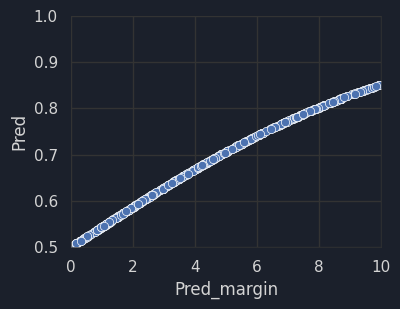

In [8]:
plt.figure(figsize=(4, 3))
sns.scatterplot(submission[submission["Pred_margin"]**2<100].sample(n=1000), x="Pred_margin", y="Pred")
plt.xlim(0, 10)
plt.ylim(0.5, 1)
plt.show();

In [9]:
men = submission[submission["TeamID_1"] < 3000]

men_1 = men[["TeamID_1", "TeamName_1", "TeamID_2", "TeamName_2", "Pred_margin"]]
men_1 = men_1.rename(columns={"TeamID_1": "TeamID", "TeamName_1": "TeamName", "TeamID_2": "OppID", "TeamName_2": "OppName"})

men_2 = men[["TeamID_1", "TeamName_1", "TeamID_2", "TeamName_2", "Pred_margin"]]
men_2 = men_2.rename(columns={"TeamID_2": "TeamID", "TeamName_2": "TeamName", "TeamID_1": "OppID", "TeamName_1": "OppName"})
men_2["Pred_margin"] = -men_2["Pred_margin"]

men = pd.concat([men_1, men_2]).sort_values("TeamID").reset_index(drop=True)
print(men.head(3))
print(men.shape)

   TeamID     TeamName  OppID    OppName  Pred_margin
0    1101  Abilene Chr   1102  Air Force    -0.032739
1    1101  Abilene Chr   1360  San Diego    -0.970217
2    1101  Abilene Chr   1359    Samford    -6.136386
(132132, 5)


In [31]:
rank = men[["TeamID", "TeamName", "Pred_margin"]][men["Pred_margin"] > 0]
rank = rank.groupby(["TeamID", "TeamName"]).count().reset_index().rename(columns={"Pred_margin": "Wins"})
rank = rank.sort_values(["Wins", "TeamID"], ascending=False).reset_index(drop=True).reset_index(names="Rank")
rank["Rank"] += 1
rank = rank.head(64)
print(rank.head(3))
print(rank.shape)

   Rank  TeamID TeamName  Wins
0     1    1120   Auburn   363
1     2    1181     Duke   362
2     3    1222  Houston   361
(64, 4)


In [61]:
bracket = []
for t in rank[["Rank", "TeamName", "TeamID"]].values:
    bracket.append(tuple(t))

higher_seeds = bracket[:32]
lower_seeds = list(reversed(bracket))[:32]

for i in [32, 16, 8, 4, 2, 1]:
    print(f"Round of {i*2}")
    for j, (t1, t2) in list(enumerate(zip(higher_seeds, lower_seeds))):
        margin = men[(men["TeamID"]==t1[2]) & (men["OppID"]==t2[2])]["Pred_margin"].squeeze()
        if margin < 0:
            higher_seeds[j] = t2
            lower_seeds[j] = t1
            margin = -margin
        team1 = f"#{higher_seeds[j][0]} {higher_seeds[j][1]}"
        print(f"{team1:>16} {-round(margin*2)/2:>5} over #{lower_seeds[j][0]} {lower_seeds[j][1]}")
    if i > 0:
        lower_seeds = list(reversed(higher_seeds))[:i//2]
        higher_seeds = higher_seeds[:i//2]
    print()

Round of 64
       #1 Auburn -10.0 over #64 Utah
         #2 Duke  -9.0 over #63 Pittsburgh
      #3 Houston  -8.5 over #62 Nevada
      #4 Florida  -7.5 over #61 Drake
    #5 Tennessee  -6.5 over #60 Nebraska
      #6 Alabama  -8.0 over #59 McNeese St
      #7 Gonzaga  -6.0 over #58 Indiana
   #8 Texas Tech  -5.0 over #57 Northwestern
     #9 Kentucky  -4.5 over #56 Colorado St
     #10 Iowa St  -4.5 over #55 San Francisco
    #11 Illinois  -4.0 over #54 Dayton
 #12 Michigan St  -4.0 over #53 Oklahoma
    #13 Missouri  -4.0 over #52 Santa Clara
     #14 Arizona  -3.0 over #51 New Mexico
   #15 St John's  -2.5 over #50 North Texas
#16 St Mary's CA  -3.0 over #49 San Diego St
      #17 Kansas  -3.0 over #48 SMU
 #18 Connecticut  -2.5 over #47 Vanderbilt
   #19 Wisconsin  -2.5 over #46 Utah St
     #20 Georgia  -1.5 over #45 Xavier
  #21 Louisville  -1.5 over #44 West Virginia
      #22 Purdue  -1.5 over #43 Villanova
        #23 UCLA  -1.0 over #42 North Carolina
   #24 Texas A&M  -1.0 